In [1]:
from Util import *

In [5]:
W, H = SIZE = (160, 90)
try:
    with open("pos.dat", "rb") as f:
        X, y = pickle.load(f)
except FileNotFoundError:
    with open("ball_markup.json", "r") as f:
        data: dict = json.load(f)
    
    X, y = [], []
    N = 4000

    cam = cv2.VideoCapture("game_1_ori.mp4")
    sorted_sample = [list(data.items())[i] for i in sorted(random.sample(range(len(data)), N))]
    for key, value in tqdm(random.sample(list(data.items()), N)):
        cam.set(cv2.CAP_PROP_POS_FRAMES, int(key))
        _, img = cam.read()
        h, w, c = img.shape
        img = cv2.resize(img, SIZE)
        X.append(cv2.split(img))
        v = [value['x']*W//w, value['y']*H//h]
        y.append(v)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    cam.release()
    with open("pos.dat", "wb") as f:
        pickle.dump((X, y), f)
train_X, val_X, test_X, train_y, val_y, test_y = preprocess(X, y, False)


In [3]:
def get_output_size(w, k, p, s):
    return (w-k+2*p)//s + 1
w = get_output_size(160, 5, 0, 2)
h = get_output_size(90, 5, 0, 2)
w = get_output_size(w, 5, 0, 2)
h = get_output_size(h, 5, 0, 2)
w = get_output_size(w, 5, 0, 2)
h = get_output_size(h, 5, 0, 2)
w = get_output_size(w, 5, 0, 2)
h = get_output_size(h, 5, 0, 2)
print(w*h*12)

168


In [2]:
net = load("posnet.dat", NN([3, 6, 9, 12, 12], [288, 2]))

 10%|█         | 1040/10000 [03:58<34:16,  4.36it/s]

Stopped at Epoch 1040
Loss: 169.13165283203125


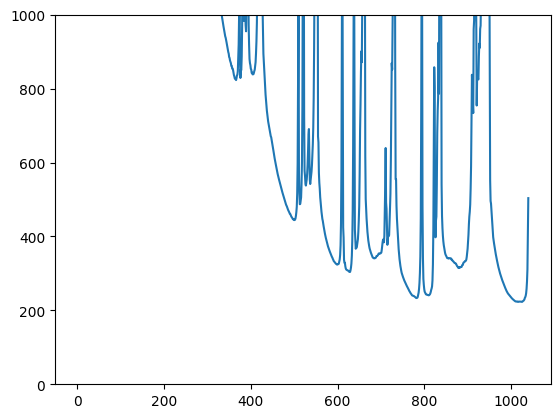

In [5]:
net.my_train(train_X, train_y, val_X, val_y, 10000)
with open("posnet.dat", "wb") as f:
    pickle.dump(net, f)

In [6]:
with open("posnet.dat", "rb") as f:
    net = pickle.load(f)
for x, y in zip(test_X, test_y):
    r, g, b = x.cpu().numpy().astype(np.uint8)
    img = cv2.merge([r, g, b])
    h, w, c = img.shape
    img = cv2.resize(img, (1200, 900))
    c = net(x.unsqueeze(0))[0]
    c = (int(c[0]*1200/w), int(c[1]*900/h))
    img = cv2.circle(img, c, 10, (0, 0, 255))
    c = (int(y[0]*1200/w), int(y[1]*900/h))
    img = cv2.circle(img, c, 20, (0, 255, 0))
    imshow(img)
    a = cv2.waitKey(0)
    if a == ord('a'):
        cv2.destroyAllWindows()

        break
    # break


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1261: error: (-27:Null pointer) NULL window: 'i' in function 'cvDestroyWindow'


In [11]:
cam = cv2.VideoCapture("game_1.mp4")
cont = True
prev = 0
left = True
streak = 0
i = 0
breaks = []
while cont:
    cont, img = cam.read()
    _, img = cam.read()
    h, w, c = img.shape
    img2 = cv2.resize(img, SIZE)
    pos = net(torch.from_numpy(np.array(cv2.split(img2), dtype=np.float32)).to("cuda:0").unsqueeze(0))
    current = int(pos[0][0])
    if (current < prev) == left:
        streak = 0
    else:
        streak += 1
        if streak == 3:
            streak = 0
            left = not left
            print(1)
    i+= 1
    prev = current
    pos = pos[0]
    new_pos = int(pos[0]*w//SIZE[0]), int(pos[1]*h//SIZE[1])
    img = cv2.circle(img, new_pos, 20, (0, 255, 0))
    imshow(img)
    a = cv2.waitKey(0)
    if a == ord('a'):
        cv2.destroyAllWindows()

        break

    

1
1
1
1
1
1
1
1
1
1
1
1
1
1


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1261: error: (-27:Null pointer) NULL window: 'i' in function 'cvDestroyWindow'


In [8]:
from collections import deque

In [6]:
cam = cv2.VideoCapture("game_1.mp4")
n = 10
prev = 0
left = True
streak = 0
i = 0
breaks = []
for _ in range(1000):
    cont, img = cam.read()
    _, img = cam.read()
    h, w, c = img.shape
    img2 = cv2.resize(img, SIZE)
    pos = net(torch.from_numpy(np.array(cv2.split(img2), dtype=np.float32)).to("cuda:0").unsqueeze(0))
    current = int(pos[0][0])
    if (current < SIZE[0]/2) == left:
        streak = 0
    else:
        streak += 1
        if streak == 3:
            streak = 0
            left = not left
            breaks.append(i)
    i+= 1
    prev = current
print(breaks)
    

[5, 9, 17, 20, 87, 90, 98, 107, 136, 163, 168, 188, 235, 240, 301, 306, 319, 325, 375, 424, 453, 456, 465, 475, 496, 517, 525, 536, 541, 568, 574, 664, 681, 684, 722, 739, 761, 793, 808, 820, 825, 848, 851, 883, 886, 891, 908, 916, 919, 933, 937, 947, 964, 974, 983]
